In [1]:
!pip install smogn

In [2]:
import os
import smogn
import torch
import imagehash
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
from PIL import Image, ImageDraw
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import StratifiedKFold

pd.set_option("max_columns", 150)
pd.set_option('display.max_rows', 150)

In [3]:
# If False, load and write the same data retrieved from previous version.
MAKE_DROP_DUPLICATED_DATA = False
MAKE_SMOGN_WITH100        = False
MAKE_SMOGN_UNDER_ADD100   = False
MAKE_SMOGN_FOLDS          = True
MAKE_SMOGN_PSEUDOLABEL    = True

In [4]:
df_train = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
df_train["path"] = [f"../input/petfinder-pawpularity-score/train/{i}.jpg" for i in df_train.Id]

df_train.shape

(9912, 15)

# Remove mislabeled data

In [5]:
if MAKE_DROP_DUPLICATED_DATA:
    funcs = [imagehash.average_hash,
             imagehash.phash,
             imagehash.dhash,
             imagehash.whash]
    def run_hash(path):
        image = Image.open(path)
        return list(np.array([f(image).hash for f in funcs]).reshape(256))

    # Extract some samples from external data for accerarating.
    paths = list(df_train.path)
    print(len(paths))

    with ThreadPoolExecutor(4) as e:
        hashes = e.map(run_hash, paths)
    hashes = [r for r in hashes]

In [6]:
if MAKE_DROP_DUPLICATED_DATA:
    hashes_all = torch.Tensor(np.array(hashes).astype(int))
    sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).cpu().numpy()/256 for i in range(hashes_all.shape[0])])
    print(sims.shape)

In [7]:
if MAKE_DROP_DUPLICATED_DATA:
    match_patterns = {}
    for i in range(sims.shape[0]):
        similar = np.where(sims[i]>0.95)[0]
        if 1 < len(similar):
            this_paw = df_train.loc[i, "Pawpularity"]
            sim_idxes = [s for s in similar if s != i]
            match_patterns[i] = sim_idxes
    print(len(match_patterns))

In [8]:
if MAKE_DROP_DUPLICATED_DATA:
    df_train_drop_duplicated = df_train.drop(list(match_patterns.keys())).reset_index(drop=True)
    df_train_drop_duplicated.drop("path", axis=1, inplace=True)
else:
    df_train_drop_duplicated = pd.read_csv("../input/petfinder-smogn-dataset/train_drop_duplicated.csv")
    
print(df_train_drop_duplicated.shape)
df_train_drop_duplicated.to_csv("./train_drop_duplicated.csv", index=False)

(9860, 14)


<AxesSubplot:>

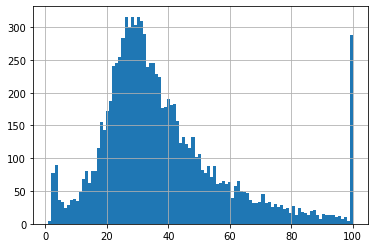

In [9]:
df_train_drop_duplicated.Pawpularity.hist(bins=100)

# Make new data

In [10]:
if MAKE_SMOGN_WITH100:
    df_train_smogn_with100 = smogn.smoter(data=df_train_drop_duplicated, y='Pawpularity')
else:
    df_train_smogn_with100 = pd.read_csv("../input/petfinder-smogn-dataset/train_smogn_with100.csv")

print(df_train_smogn_with100.shape)
df_train_smogn_with100.to_csv("./train_smogn_with100.csv", index=False)

(8259, 14)


In [11]:
if MAKE_SMOGN_UNDER_ADD100:
    df_train_100      = df_train_drop_duplicated[df_train_drop_duplicated.Pawpularity == 100].reset_index(drop=True)
    print(df_train_100.shape)

    df_train_under100 = df_train_drop_duplicated[df_train_drop_duplicated.Pawpularity  < 100].reset_index(drop=True)
    print(df_train_under100.shape)

    df_train_smogn_under100 = smogn.smoter(data=df_train_under100, y='Pawpularity')
    df_train_smogn_add100   = pd.concat([df_train_smogn_under100, df_train_100]).reset_index(drop=True)
else:
    df_train_smogn_under100 = pd.read_csv("../input/petfinder-smogn-dataset/train_smogn_under100.csv")
    df_train_smogn_add100   = pd.read_csv("../input/petfinder-smogn-dataset/train_smogn_add100.csv")
    
print(df_train_smogn_under100.shape)
print(df_train_smogn_add100.shape)
df_train_smogn_under100.to_csv("./train_smogn_under100.csv", index=False)
df_train_smogn_add100.to_csv("./train_smogn_add100.csv", index=False)

(8101, 14)
(8389, 14)


<AxesSubplot:>

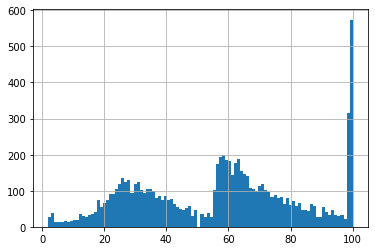

In [12]:
df_train_smogn_with100.Pawpularity.hist(bins=100)

<AxesSubplot:>

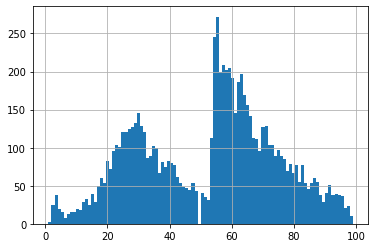

In [13]:
df_train_smogn_under100.Pawpularity.hist(bins=100)

<AxesSubplot:>

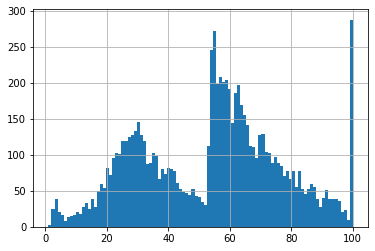

In [14]:
df_train_smogn_add100.Pawpularity.hist(bins=100)

In [15]:
df_fold  = df_train_drop_duplicated.copy()
df_fold["Pawclass"] = df_fold.Pawpularity / 100

num_bins = int(np.ceil(2*((len(df_fold))**(1./3))))
df_fold['bins'] = pd.cut(df_fold['Pawclass'], bins=num_bins, labels=False)

In [16]:
kfold = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)
df_fold["fold"] = 0
for i, (_, train_index) in enumerate(kfold.split(df_fold.index, df_fold['bins'])):
    df_fold.loc[train_index, "fold"] = i
df_fold['fold'] = df_fold['fold'].astype('int')

df_fold.fold.value_counts()

3    2465
1    2465
2    2465
0    2465
Name: fold, dtype: int64

In [17]:
%%time
if MAKE_SMOGN_FOLDS:
    df_smogn_fold = pd.DataFrame()
    for fold in range(4):
        print(f"Running with fold {fold}...")
        df_train = df_fold[df_fold.fold != fold]
        df_train_under100 = df_train[df_train.Pawpularity <  100].reset_index(drop=True)
        df_train_only100  = df_train[df_train.Pawpularity == 100].reset_index(drop=True)
        df_valid = df_fold[df_fold.fold == fold].reset_index(drop=True)
        df_train_smogn = smogn.smoter(data=df_train_under100.copy(), y='Pawpularity')
        df_train_smogn["fold"]  = fold
        df_train_smogn["train"] = 1
        df_train_only100["fold"]  = fold
        df_train_only100["train"] = 1
        df_valid["train"] = 0
        df_smogn_fold = df_smogn_fold.append(pd.concat([df_train_smogn, df_train_only100, df_valid]))
        print(f"Fold {fold} has {df_train_smogn.shape[0] + df_train_only100.shape[0]} training data and {df_valid.shape[0]} validation data")
        print("-----------------------------------")
    df_smogn_fold = df_smogn_fold.drop(["Pawclass","bins"], axis=1).reset_index(drop=True)
else:
    df_smogn_fold = pd.read_csv("../input/petfinder-smogn-dataset/train_smogn_fold4.csv")
    
print(df_smogn_fold.shape)
df_smogn_fold.to_csv("./train_smogn_fold4.csv", index=False)

Running with fold 0...


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
r_index: 100%|##########| 285/285 [00:01<00:00, 264.41it/s]


Fold 0 has 6294 training data and 2465 validation data
-----------------------------------
Running with fold 1...


r_index: 100%|##########| 279/279 [00:01<00:00, 268.33it/s]


Fold 1 has 6291 training data and 2465 validation data
-----------------------------------
Running with fold 2...


r_index: 100%|##########| 277/277 [00:01<00:00, 261.86it/s]


Fold 2 has 6290 training data and 2465 validation data
-----------------------------------
Running with fold 3...


r_index: 100%|##########| 275/275 [00:01<00:00, 260.00it/s]


Fold 3 has 6290 training data and 2465 validation data
-----------------------------------
(35025, 16)
CPU times: user 1h 3min 48s, sys: 3.61 s, total: 1h 3min 52s
Wall time: 1h 3min 50s


<AxesSubplot:>

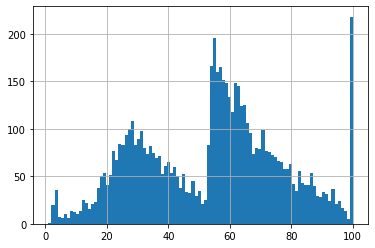

In [18]:
df_smogn_fold[(df_smogn_fold.fold == 0)&(df_smogn_fold.train == 1)].Pawpularity.hist(bins=100)

In [19]:
if MAKE_SMOGN_PSEUDOLABEL:
    df_train_pseudo = pd.read_csv("../input/petfinder-pseudolabel-dataset/train.csv")
    df_train_smogn_pseudo = smogn.smoter(data=df_train_pseudo.copy(), y='Pawpularity')
else:
    df_train_smogn_pseudo = pd.read_csv("../input/petfinder-smogn-dataset/train_smogn_pseudolabel.csv")

print(df_train_smogn_pseudo.shape)
df_train_smogn_pseudo.to_csv("./train_smogn_pseudolabel.csv", index=False)

r_index: 100%|##########| 4649/4649 [00:04<00:00, 1134.27it/s]


(50142, 2)


<AxesSubplot:>

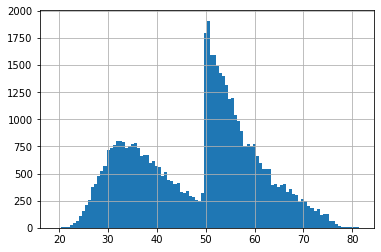

In [20]:
df_train_smogn_pseudo.Pawpularity.hist(bins=100)